# Preprocesamiento de Datos

El preprocesamiento de datos - a veces también conocido como transformación de datos o, incluso, ingeniería de atributos - es probablemente una de las parte más importante del trabajo del Data Scientist, tal vez la más importante. Como habrás visto en la bitácora, son muchos los pasos involucrados en este proceso, y eso que no los hemos mencionados a todos, pero sí los más importantes. En este notebook, trabajaremos sobre cuatro grandes áreas:

1. Valores Faltantes
2. Valores Atípicos
3. Escalado de Datos
4. Encoders

Como este notebook corresponde a dos bitácoras y encuentros (19 y 20), no te preocupes si todavía no sabes de qué se tratan los puntos 3 y 4.

Antes de arrancar, una pregunta usual que suele surgir es si usar Pandas o Scikit-Learn, ya que algunos de estos pasos pueden hacerse indistintamente con cualquiera de las dos librerías. Como siempre, la respuesta depende de lo que quieras hacer - y también con cuál herramienta te sientas más cómodo/a. Pero una respuesta rápida es que si estas explorando datos, mejor usar Pandas. Si estás en un flujo de Machine Learning, Scikit-Learn. Probablemente, termines usando las dos en un mismo notebook.

#### Algunas referencias

**Muy útil:** [documentación de Scikit-Learn sobre preprocesamiento de datos](https://scikit-learn.org/stable/modules/preprocessing.html)

**Valores Faltantes**

* En Pandas, explora las funcionalidades `isna()`, `dropna()` y `fillna()`.
* En Scikit-Learn, explora la clase `SimpleImputer`.

**Valores Atípicos**

* Para aplicar los criterios que mencionamos, bastará usar las técnicas de visualización que ya conoces, calcular percentiles, promedios y desviaciones estándar con NumPy o Pandas, y usar máscaras.
* En Scikit-Learn existen métodos para trabajar con valores atípicos. Si bien no los utilizaremos, no está demás si quieres mirarlos [aquí](https://scikit-learn.org/stable/modules/outlier_detection.html).

**Escalado de Datos**
* Se puede hacer a mano con las herramientas de NumPy o Pandas
* En Scikit-Learn existe una variedad de clases que pueden ayudarte en este proceso. Puedes mirar en el enlace a la documentación de Scikit-Learn que dejamos más arriba.

**Encoders**
* En Pandas, explora las funcionalidades `get_dummies()` y `map()`
* En Scikit-Learn, explora la clase `LabelEncoder` y `OneHotEncoder`.


## 1. Valores Faltantes

En este ejercicio te proveemos de un dataset de seis columnas y 1500 instancias. Salvo una columna, `V1`, todas tienen valores faltantes. De las columnas con valores faltantes:
* Dos tienen valores faltantes MCAR (el valor faltante es completamente al azar y no depende de otras variables)
* Una tiene valores faltantes MAR (la probabilidad de valor faltante depende de otra variable).
* Una tiene valores faltantes MNAR (la probabilidad de valor faltante depende de esa misma variable).

### 1.1 MCAR, MAR o MNAR - **Opcional**

El objetivo de esta sección es que analisis el origen de estos valores faltantes. Para ello:

1. Abre los datos y explóralos. Con ese fin, te recomendamos hacer un `pairplot` (con y sin `hue`) de Seaborn y contar los valores faltantes por columna. ¿Qué tipo de datos son?¿Cuáles son sus distribuciones?¿Te parece que hay alguna columna correlacionada con otra?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datos = pd.read_csv("../datasets/DS_Bitácora_19_Data_con_VF.csv")

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      1500 non-null   object 
 1   V2      1341 non-null   float64
 2   V3      1396 non-null   float64
 3   V4      1087 non-null   float64
 4   V5      1382 non-null   float64
dtypes: float64(4), object(1)
memory usage: 58.7+ KB


In [4]:
datos.describe()

,V2,V3,V4,V5
count,1341.000000,1396.000000,1087.000000,1382.000000
mean,0.500373,999.686269,196.414056,2395.781409
std,0.500186,24.099044,8.986208,131.714318
min,0.000000,916.828247,166.654303,2005.861180
25%,0.000000,984.023781,190.708818,2306.219362
50%,1.000000,999.385885,196.753671,2397.870540
75%,1.000000,1015.946214,202.423761,2480.880485
max,1.000000,1082.767001,225.195704,2866.799351


In [5]:
datos.head()

,V1,V2,V3,V4,V5
0,C,1.0,986.175237,184.258917,2224.638050
1,C,1.0,994.130276,NaN,2570.213101
2,A,1.0,985.782622,196.893581,2309.238832
3,A,1.0,1029.464887,192.063247,2349.259233
4,A,1.0,1004.357092,NaN,2474.036357


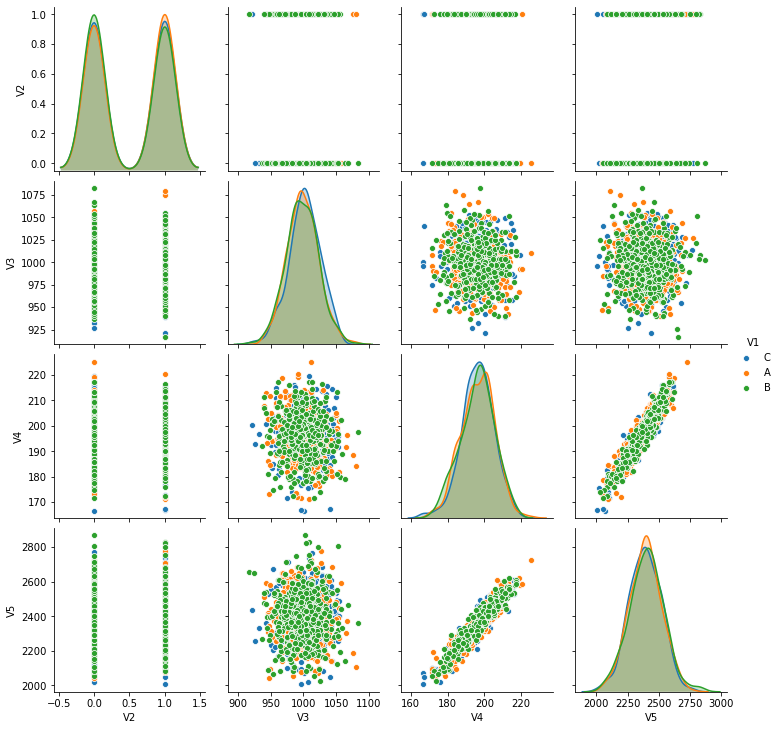

In [6]:
sns.pairplot(data=datos,hue='V1')

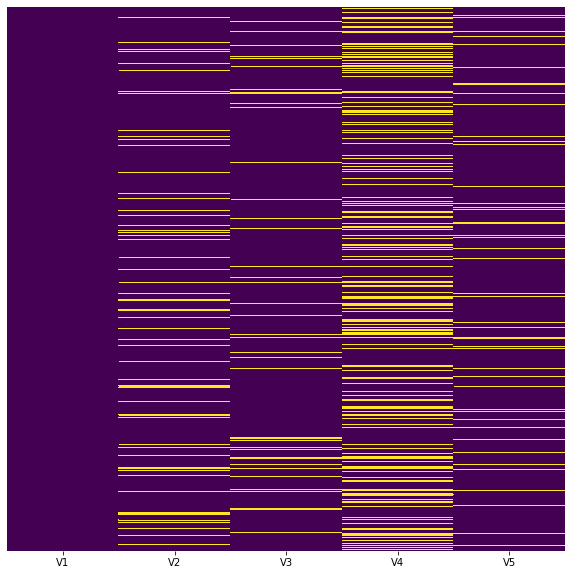

V1      0
V2    159
V3    104
V4    413
V5    118
dtype: int64

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(datos.isnull(),cbar=False,yticklabels=False,cmap='viridis')
plt.show()
datos.isnull().sum()

,V2,V3,V4,V5
V2,1.000000,-0.008979,-0.018572,0.000571
V3,-0.008979,1.000000,-0.067935,-0.029989
V4,-0.018572,-0.067935,1.000000,0.934933
V5,0.000571,-0.029989,0.934933,1.000000


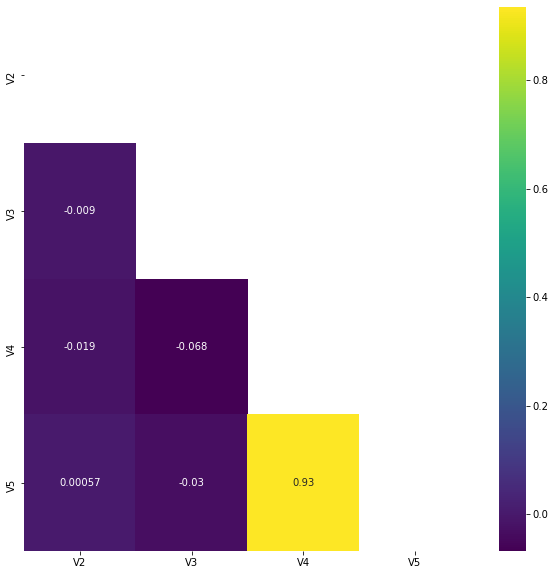

In [8]:
plt.figure(figsize=(10,10))
matrix = np.triu(datos.corr())
sns_plot = sns.heatmap(datos.corr(),cmap='viridis',mask=matrix, annot = True)
figure = sns_plot.get_figure()  
figure.savefig("matrix.png")
datos.corr()

2. Buscaremos decidir el mecanismo que dio origen a los valores faltante de cada columna. Para ello, ten en cuenta que:
* Para simplificar el análisis, si hay valores MAR, la dependencia sólo puede ser con la columna categórica sin valores faltantes, `V1`. Entonces, basta que solamente pruebes dependencia con esa variable. Te puede ser **muy útil** [esta pregunta de Stack Overflow](https://stackoverflow.com/questions/43321455/pandas-count-null-values-in-a-groupby-function/43322220).
* MNAR puede es difícil de estudiar si no tenemos conocimiento del tema o si no hay una variable que correlacione con la variable que queremos estudiar para usar de *proxy*. ¿Qué queremos decir con esto? Imaginate que tienes una planilla con sueldos mensuales de personas y vas a borrar valores con mayor probabilidad si son más altos. Pero no te diste cuenta que en otra planilla figuran el estimativo del sueldo anual, lo cual correlaciona fuertemente con el sueldo mensual. Entonces, si quieres ver si la probabilidad de borrar un valor estaba relacionada con ese valor, lo que puedes hacer es crear intervalos para la variables sin valores faltantes - es decir, crear rangos de sueldos anuales - y contar cuántas instancias que caen dentro de ese intervalo tienen valores faltantes en la variable borrada (sueldo mensual). Al principio es muy confuso, pero piénsalo un rato y vas a ver que tiene sentido.
* MCAR es un mecanismo que puede ser difícil de estudiar. Tal vez es más probable que llegues a él *por descarte* de los otros dos mecanismos.

**MAR con respecto a `V1`**

Dejamos la línea casi completa para el caso de `V2`:

In [9]:
datos.V2.isnull().groupby([datos['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,39
1,B,52
2,C,68


In [10]:
datos.V3.isnull().groupby([datos['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,30
1,B,0
2,C,74


In [11]:
datos.V4.isnull().groupby([datos['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,139
1,B,147
2,C,127


In [12]:
datos.V5.isnull().groupby([datos['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,34
1,B,44
2,C,40


**MNAR**

Las únicas variables correlacionadas son `V4` y `V5`, ambas con valores faltantes. Entonces, podemos usar una para ver si los valores faltantes de la otra son **MNAR**.

Arranquemos estudiando los valores faltante en `V5`. Para ello, debemos binear `V4` y contar cuántos valores faltantes de `V5` caen en cada intervalo. Entonces, creamos los intervalos para `V4`

In [13]:
datos['V4-intervalos'] = pd.cut(datos.V4, bins  = 15)
datos.head()

,V1,V2,V3,V4,V5,V4-intervalos
0,C,1.0,986.175237,184.258917,2224.638050,"(182.265, 186.168]"
1,C,1.0,994.130276,NaN,2570.213101,NaN
2,A,1.0,985.782622,196.893581,2309.238832,"(193.974, 197.876]"
3,A,1.0,1029.464887,192.063247,2349.259233,"(190.071, 193.974]"
4,A,1.0,1004.357092,NaN,2474.036357,NaN


y contamos cuántas instancias por intervalo tienen valores faltantes en `V5`.

In [14]:
vf_V4V5 = datos.V5.isnull().groupby([datos['V4-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V4V5

,V4-intervalos,count
0,"(166.596, 170.557]",0
1,"(170.557, 174.46]",0
2,"(174.46, 178.363]",1
3,"(178.363, 182.265]",2
4,"(182.265, 186.168]",5
5,"(186.168, 190.071]",6
6,"(190.071, 193.974]",17
7,"(193.974, 197.876]",12
8,"(197.876, 201.779]",20
9,"(201.779, 205.682]",13


Pero en realidad lo que nos interesa es la frecuencia de estos valores faltantes, porque no todos los intervalos tienen la misma cantidad de instancias.

In [15]:
vf_V4V5['freq'] = vf_V4V5['count']/datos.groupby([datos['V4-intervalos']]).count()['V4'].values
vf_V4V5

,V4-intervalos,count,freq
0,"(166.596, 170.557]",0,0.000000
1,"(170.557, 174.46]",0,0.000000
2,"(174.46, 178.363]",1,0.062500
3,"(178.363, 182.265]",2,0.051282
4,"(182.265, 186.168]",5,0.060976
5,"(186.168, 190.071]",6,0.063830
6,"(190.071, 193.974]",17,0.104938
7,"(193.974, 197.876]",12,0.065217
8,"(197.876, 201.779]",20,0.109290
9,"(201.779, 205.682]",13,0.084416


Para que sea más fácil e informativo el gráfico, agregamos a este dataframe el punto medio de cada intervalo.

In [16]:
vf_V4V5["bin_centres"] = vf_V4V5["V4-intervalos"].apply(lambda x: x.mid)
vf_V4V5

,V4-intervalos,count,freq,bin_centres
0,"(166.596, 170.557]",0,0.000000,168.5765
1,"(170.557, 174.46]",0,0.000000,172.5085
2,"(174.46, 178.363]",1,0.062500,176.4115
3,"(178.363, 182.265]",2,0.051282,180.3140
4,"(182.265, 186.168]",5,0.060976,184.2165
5,"(186.168, 190.071]",6,0.063830,188.1195
6,"(190.071, 193.974]",17,0.104938,192.0225
7,"(193.974, 197.876]",12,0.065217,195.9250
8,"(197.876, 201.779]",20,0.109290,199.8275
9,"(201.779, 205.682]",13,0.084416,203.7305


y finalmente, graficamos

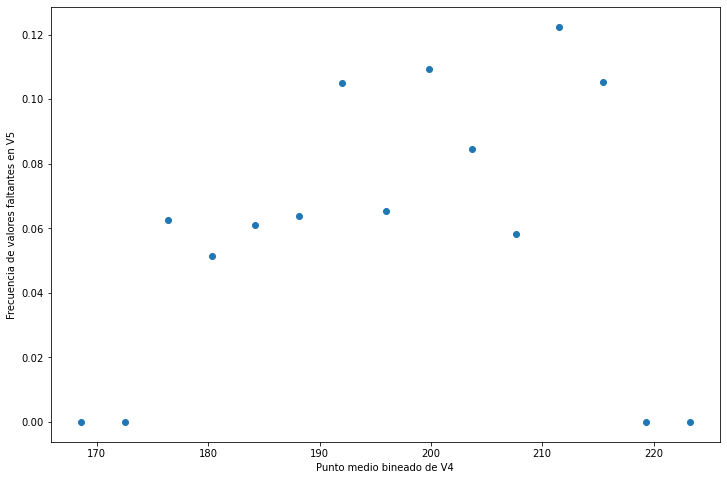

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(vf_V4V5['bin_centres'], vf_V4V5['freq'])
plt.xlabel('Punto medio bineado de V4')
plt.ylabel('Frecuencia de valores faltantes en V5')
plt.show()

¿Te parece que da alguna información este gráfico? No te apures a sacar conclusiones. Vuelve a repetir los pasos, pero invirtiendo el rol de `V5` y `V4` - solamente tienes que copiar cada celda e intercalar los nombres. Una vez que hayas llegado al gráfico, ahora sí mira si puedes sacar alguna conclusión.

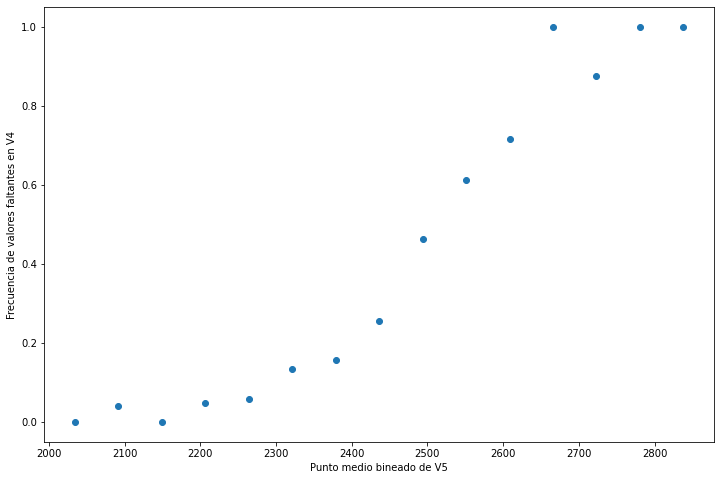

In [20]:
datos['V5-intervalos'] = pd.cut(datos.V5, bins  = 15)
vf_V5V4 = datos.V4.isnull().groupby([datos['V5-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V5V4['freq'] = vf_V5V4['count']/datos.groupby([datos['V5-intervalos']]).count()['V5'].values
vf_V5V4["bin_centres"] = vf_V5V4["V5-intervalos"].apply(lambda x: x.mid)
plt.figure(figsize=(12,8))
plt.scatter(vf_V5V4['bin_centres'], vf_V5V4['freq'])
plt.xlabel('Punto medio bineado de V5')
plt.ylabel('Frecuencia de valores faltantes en V4')
plt.show()

¿Has llegado a alguna conclusión? Entre `V4` y `V5`, ¿cuál es MNAR y cuál MCAR?¿Y `V2`?

## 1.2 Imputación de valores faltantes

Vamos a *imputar* los valores faltantes sobre el dataset sintético y el dataset de Distrofia. 

### 1.2.1 Dataset Sintético

Te recomendamos que:

1. Al tratarse de un dataset pequeño, puedes copiar el dataset, dejar a un lado el original y rellenar valores faltantes en la copia. De esta forma, podrás evaluar tu estrategia (ver punto siguiente) y/o comparar distintas estrategias.
1. Haz histogramas de las variables con y sin valores faltantes. Al imputar, ¿cambián las distribuciones?¿Esto está bien o mal?

**Ejercicio 1 - Challenge 1:** Comienza con una estrategia sencilla, imputar con el valor medio de cada columna usando Pandas. ¿Para cuáles columnas tendrá sentido esto, teniendo en cuenta lo visto en el punto anterior? 

**Ejercicio 2:** Propone - e implementa - una estrategia que consideres mejor, incorporando la información del punto 1. En el siguiente encuentro, te daremos el dataset sin valores faltantes, por lo que podrás comparar tus resultados. ¡Ten en cuenta que es muy raro que esto se pueda hacer! Lo que nos lleva a...

**Ejercicio 3:** ¿Se te ocurre algún mecanismo de evaluación de tu estrategia? Pista: considera lo que vimos sobre Machine Learning en el Bloque 1 de la carrera. 

Por las dudas, comenzamos volviendo a cargar los datos:

In [2]:
data = pd.read_csv("../datasets/DS_Bitácora_19_Data_con_VF.csv")
data_copy = data.copy()
data_copy.fillna(data_copy.mean(), inplace=True)
data_copy.isna().sum()

V1    0
V2    0
V3    0
V4    0
V5    0
dtype: int64

In [3]:
data_copy.mean()

V2       0.500373
V3     999.686269
V4     196.414056
V5    2395.781409
dtype: float64

In [13]:
data_copy[data.isna().sum(axis=1)>1]

,V1,V2,V3,V4,V5
29,C,0.500373,1003.140577,196.414056,2395.781409
44,C,0.500373,1008.296098,196.414056,2585.791324
68,C,1.000000,999.686269,196.414056,2395.781409
95,A,0.500373,1005.049945,196.414056,2473.818953
102,C,0.000000,999.686269,196.414056,2461.184805
...,...,...,...,...,...
1447,B,0.000000,998.081790,196.414056,2395.781409
1453,B,0.000000,1004.136207,196.414056,2395.781409
1459,B,0.500373,1048.573891,196.414056,2470.051102
1473,C,0.500373,999.686269,195.637183,2380.681004


In [9]:
data.head()

,V1,V2,V3,V4,V5
0,C,1.0,986.175237,184.258917,2224.638050
1,C,1.0,994.130276,NaN,2570.213101
2,A,1.0,985.782622,196.893581,2309.238832
3,A,1.0,1029.464887,192.063247,2349.259233
4,A,1.0,1004.357092,NaN,2474.036357


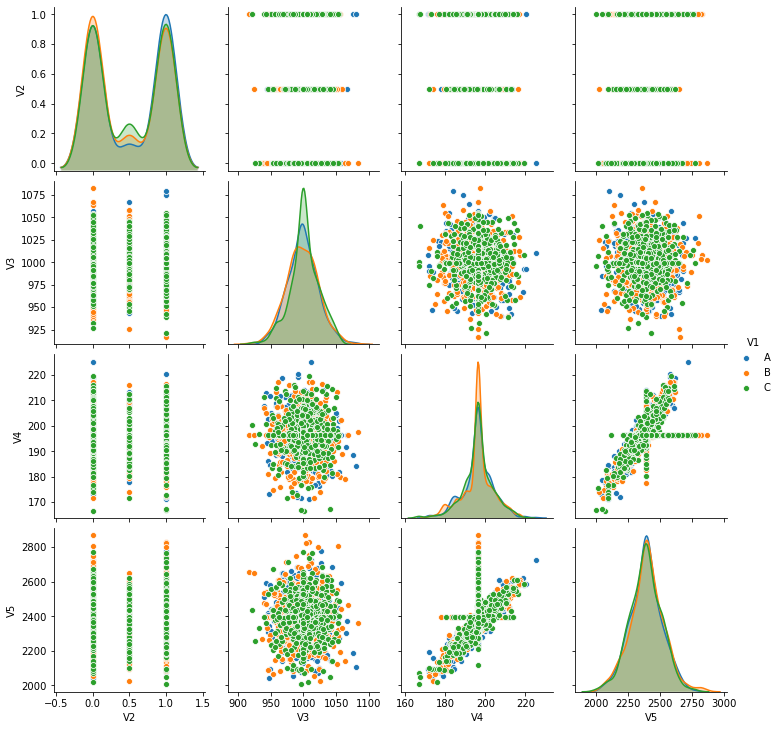

In [24]:
sns.pairplot(data_copy,hue='V1',hue_order=['A','B','C'])

### 1.2.2 Distrofia

La Distrofia Muscular de Duchenne (DMD) es una enfermedad que se transmite genéticamente de madres a hijos e hijas. Mientras que los varones mueren a temprana edad, las mujeres pueden llevar la enfermedad sin saberlo y sin síntomas. Se estima que 1 de cada 3300 mujeres son portadoras de la enfermedad.

Si bien portadoras de DMD no suelen tener síntomas, tienden a exhibir elevados niveles de enzimas o proteínas del suero, como creatina quinasa (CK, por sus siglas en inglés), hemopexina (H), lactato deshidrogenasa (LD) y piruvato quinasa (PK, por sus siglas en inglés). Los niveles de estas enzimas también pueden variar con la edad y la estación. En un estudio llevado a cabo a finales de la década del 70 se midieron esas enzimas en portadoras y no-portadoras de la enfermedad, para estudiar la posibilidad de informar a mujeres la posibilidad de que sean portadoras. Los resultados los pueden encontrar en el archivo `DS_Bitácora_19_Distrofia.csv`.

En este dataset hay valores faltantes en dos de sus columnas. Estos valores faltantes no aparecerán inmediatamente como `NaN` cuando abran el dataset con Pandas, sino que están guardados con un valor en particular. Abre y explora el dataset para descubrir ese valor. Luego, investiga como puedes pasar como argumento a la función de Pandas `read_csv` para que cuando cargue los datos ya los reconozca como valores faltantes. ¿Qué tipo de valores faltantes son?¿Están asociados a los valores de otras columnas? Luego, imputa los valores faltantes. 

In [25]:
dmd = pd.read_csv("../datasets/DS_Bitácora_19_Distrofia.csv")

In [26]:
dmd.head()

,edad,mes,año,CK,H,PK,LD,DMD
0,22.0,6.0,79.0,52.0,83.5,10.9,176.0,0
1,32.0,8.0,78.0,20.0,77.0,11.0,200.0,0
2,36.0,7.0,78.0,28.0,86.5,13.2,171.0,0
3,22.0,11.0,79.0,30.0,104.0,22.6,230.0,0
4,23.0,1.0,78.0,40.0,83.0,15.2,205.0,0


In [27]:
dmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   edad    209 non-null    float64
 1   mes     209 non-null    float64
 2   año     209 non-null    float64
 3   CK      209 non-null    float64
 4   H       209 non-null    float64
 5   PK      209 non-null    float64
 6   LD      209 non-null    float64
 7   DMD     209 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [28]:
dmd.describe()

,edad,mes,año,CK,H,PK,LD,DMD
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,32.157895,6.569378,78.641148,92.260766,84.285167,-367.277512,-142.956938,0.358852
std,8.572594,2.916501,0.572134,152.895531,17.063916,1926.195428,1840.585939,0.480815
min,20.000000,1.000000,77.000000,15.000000,9.000000,-9999.000000,-9999.000000,0.000000
25%,26.000000,4.000000,78.000000,30.000000,78.000000,10.100000,145.000000,0.000000
50%,31.000000,7.000000,79.000000,41.000000,86.000000,13.000000,176.000000,0.000000
75%,36.000000,9.000000,79.000000,73.000000,93.200000,17.100000,230.000000,1.000000
max,61.000000,12.000000,80.000000,1288.000000,118.000000,110.000000,593.000000,1.000000


In [36]:
dmd = pd.read_csv("../datasets/DS_Bitácora_19_Distrofia.csv",na_values=-9999)

In [37]:
dmd.describe()

,edad,mes,año,CK,H,PK,LD,DMD
count,209.000000,209.000000,209.000000,209.000000,209.000000,201.000000,202.000000,209.000000
mean,32.157895,6.569378,78.641148,92.260766,84.285167,16.074627,198.589109,0.358852
std,8.572594,2.916501,0.572134,152.895531,17.063916,11.882794,73.917760,0.480815
min,20.000000,1.000000,77.000000,15.000000,9.000000,2.800000,66.000000,0.000000
25%,26.000000,4.000000,78.000000,30.000000,78.000000,10.300000,148.250000,0.000000
50%,31.000000,7.000000,79.000000,41.000000,86.000000,13.700000,177.000000,0.000000
75%,36.000000,9.000000,79.000000,73.000000,93.200000,17.400000,231.750000,1.000000
max,61.000000,12.000000,80.000000,1288.000000,118.000000,110.000000,593.000000,1.000000


In [38]:
dmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   edad    209 non-null    float64
 1   mes     209 non-null    float64
 2   año     209 non-null    float64
 3   CK      209 non-null    float64
 4   H       209 non-null    float64
 5   PK      201 non-null    float64
 6   LD      202 non-null    float64
 7   DMD     209 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [41]:
dmd.isnull().sum()

edad    0
mes     0
año     0
CK      0
H       0
PK      8
LD      7
DMD     0
dtype: int64

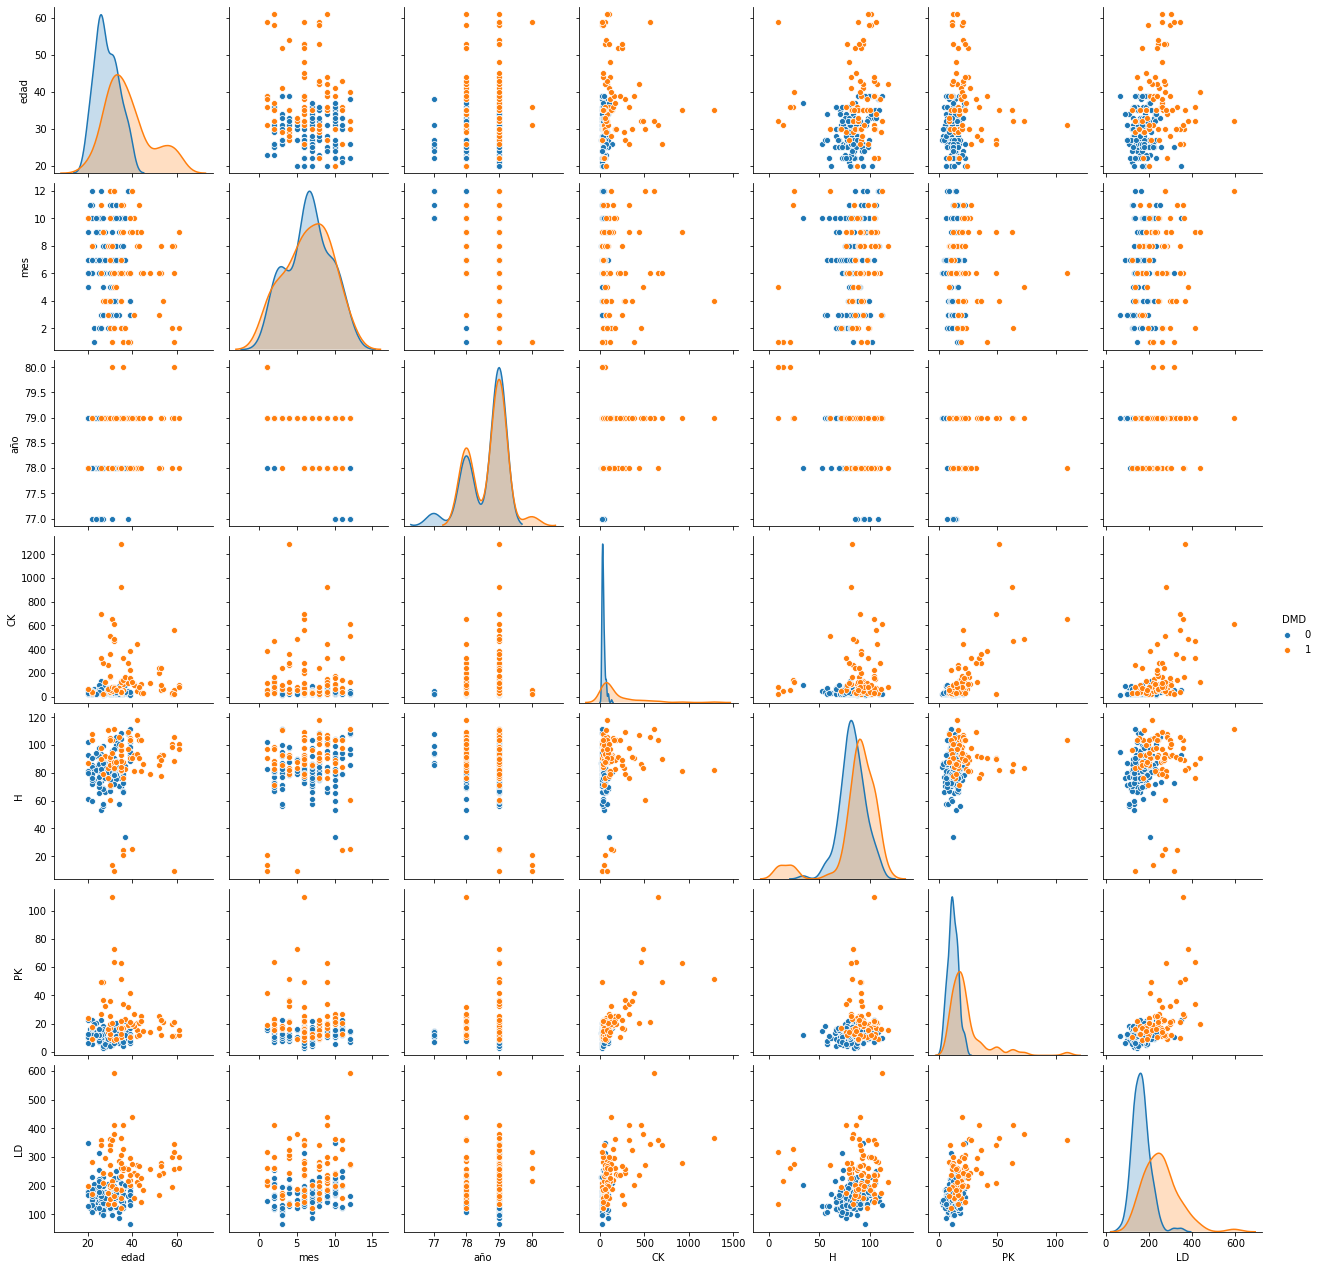

In [39]:
sns.pairplot(data=dmd,hue='DMD')

,edad,mes,año,CK,H,PK,LD,DMD
edad,1.000000,-0.096490,0.098848,0.157720,0.113072,0.090029,0.300876,0.522730
mes,-0.096490,1.000000,-0.456088,-0.008507,0.153114,-0.033261,0.157808,-0.012697
año,0.098848,-0.456088,1.000000,0.087939,-0.279372,-0.022706,0.082410,0.085879
CK,0.157720,-0.008507,0.087939,1.000000,0.081774,0.730396,0.579248,0.465596
H,0.113072,0.153114,-0.279372,0.081774,1.000000,0.150562,0.128271,0.105131
PK,0.090029,-0.033261,-0.022706,0.730396,0.150562,1.000000,0.564959,0.468784
LD,0.300876,0.157808,0.082410,0.579248,0.128271,0.564959,1.000000,0.600291
DMD,0.522730,-0.012697,0.085879,0.465596,0.105131,0.468784,0.600291,1.000000


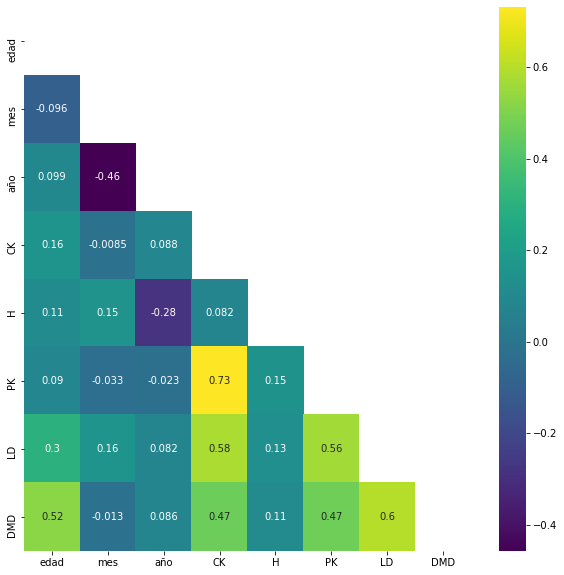

In [40]:
plt.figure(figsize=(10,10))
matrix = np.triu(dmd.corr())
sns_plot = sns.heatmap(dmd.corr(),cmap='viridis',mask=matrix, annot = True)
figure = sns_plot.get_figure()  
dmd.corr()

In [42]:
# tenemos datos faltantes en PK y CK, ambos esta correlacionados con CK

## 2. Valores Atípicos

Los datos que usaremos en esta sección, "DS_Bitácora_19_Data_VA1.csv" y "DS_Bitácora_19_Data_VA2.csv", fueron simulados con algún criterio desconocido. Uno de los archivos contiene "valores atípicos" y el otro no. El objetivo de esta sección es que decidan en cuál de ellos hay outliers y apliquen las técnicas vistas para detectarlos.

Empieza por uno de los archivos, y, una vez que hayas terminado, repite para el otro.


1. Exploración de datos.
    1. Abrir los datos y explorarlos. Para ello, recomendamos hacer un `distplot` y un `boxplot`. ¿Hay valores atípicos? Si los hay, ¿en qué región del dominio?
    2. Calcular algunos estadísticos sobre la muestra: valor medio, desviación estándar, cuartiles, máximo, mínimo, etc.
2. Manejo de Outliers
    1. Aplicar la técnica del rango interquartílico y la regla de las tres sigmas para seleccionar outliers. ¿Cuántos valores selecciona cada técnica?¿Seleccionan los mismos valores?
    2. Supongamos que seleccionamos outliers y los descartamos. ¿Qué pasa si volvemos a aplicar estas técnicas?

**1. Exploración de Datos**

In [56]:
data = pd.read_csv('../datasets/DS_Bitácora_19_Data_VA1.csv')
data.head()

,Datos
0,2.370556
1,3.437876
2,6.300131
3,5.403170
4,5.722120


<AxesSubplot:>

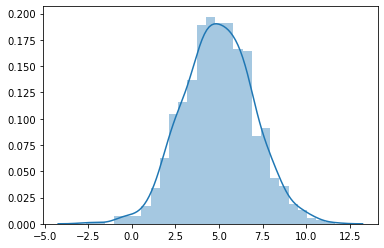

In [57]:
sns.distplot(data)

<AxesSubplot:>

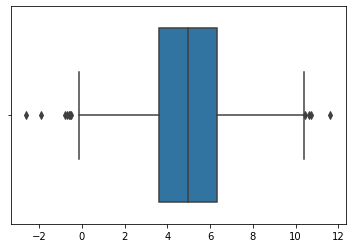

In [58]:
sns.boxplot(data)

In [59]:
data.describe()

,Datos
count,1000.000000
mean,4.952783
std,2.008023
min,-2.619781
25%,3.607388
50%,4.960488
75%,6.332730
max,11.628151


**2. Manejo de outliers**

No hay una sola forma de aplicar estas reglas.

1. Rango Intercuartílico

In [63]:
q25,q75 = np.percentile(data.Datos.values,[25,75])
iqr = q75 - q25
minimo = q25 - 1.5 * iqr
maximo = q75 + 1.5 * iqr
print(q25,q75,iqr, minimo, maximo)

3.6073881122339304 6.33273017886759 2.7253420666336594 -0.4806249877165585 10.42074327881808


In [64]:
data.Datos < minimo

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Datos, Length: 1000, dtype: bool

In [66]:
mascara_outliers = (data.Datos < minimo) | (data.Datos > maximo)
mascara_outliers.sum()

11

In [67]:
data[mascara_outliers]

,Datos
181,-1.925574
195,-0.486077
309,-0.537363
426,-2.619781
495,-0.601945
525,-0.776018
534,10.626484
540,10.424289
624,11.628151
649,-0.691831


2. Regla de las tres sigmas

In [68]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
minimo = valor_medio - 3 * std
maximo = valor_medio + 3 * std
mascara_outliers = np.logical_or(data.Datos < minimo, data.Datos > maximo)

In [69]:
mascara_outliers.sum()

3

In [70]:
data[mascara_outliers]

,Datos
181,-1.925574
426,-2.619781
624,11.628151


## 3. Escalado de datos - Challenge 2

Seguiremos usando los datos de la sección anterior:

1. Agregar al dataframe una columna que se llame "Datos_Reescalados" y que contenga los datos reescalados por Z-Score. ¿Cuál es el valor medio de los datos reescalados?¿Y su desviación estándar? **Nota:** Para reescalar los datos, pueden hacerlo "a mano" o utilizar la clase `StandardScaler` de Scikit-Learn. No te olvides que las herramientas de preprocesamiento de datos de Scikit-learn tienen los mismos métodos (crear el objeto, fitearlo, transfromar los datos). Si necesitás ayuda, podés consultar la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Realizá, en un mismo gráfico, un histograma de los datos reescaleados y un histograma de los datos crudos. ¿Qué similitudes y qué diferencias tiene con la distribución de datos crudos?
3. Aplica la regla de las tres sigmas utilizando los datos reescalados.
    

In [71]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
data['Datos_Reescalados'] = (data.Datos - valor_medio) / std
data.head()

,Datos,Datos_Reescalados
0,2.370556,-1.285955
1,3.437876,-0.754427
2,6.300131,0.670982
3,5.403170,0.224294
4,5.722120,0.383131
